In [15]:
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data
#Define Directories for train, test & Validation Set
train_path = 'D:/Paper Publication (Our work)/Malaria/train'
test_path = 'D:/Paper Publication (Our work)/Malaria/test'
valid_path = 'D:/Paper Publication (Our work)/Malaria/val'
#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16 
#The dimension of the images we are going to define is 500x500 
img_height = 500
img_width = 500

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [17]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 27558 images belonging to 2 classes.
Found 6848 images belonging to 2 classes.
Found 4108 images belonging to 2 classes.


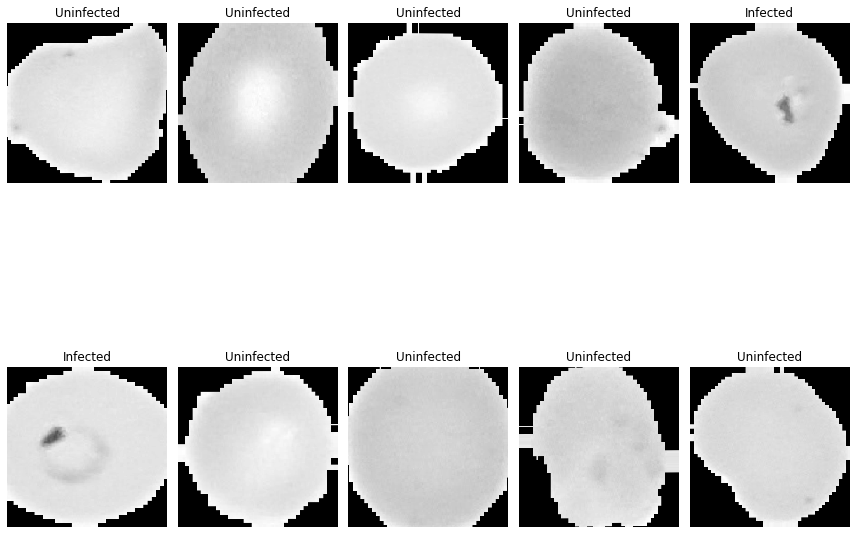

In [18]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'Infected', 1:'Uninfected'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [20]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [21]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 121, 121, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 230400)           

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [23]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [24]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.0, 1: 1.0}


C:\Users\Notebook\anaconda3\envs\tensorflow2.0\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [26]:
cnn.fit(train,epochs=15, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/15
1723/1723 [==============================] - 2608s 2s/step - loss: 0.6188 - acc: 0.6381 - val_loss: 0.7371 - val_acc: 0.5175
Epoch 2/15
1723/1723 [==============================] - 2587s 2s/step - loss: 0.2881 - acc: 0.9004 - val_loss: 0.1836 - val_acc: 0.9540
Epoch 3/15
1723/1723 [==============================] - 2565s 1s/step - loss: 0.2251 - acc: 0.9257 - val_loss: 0.1783 - val_acc: 0.9518
Epoch 4/15
1723/1723 [==============================] - 2550s 1s/step - loss: 0.1943 - acc: 0.9394 - val_loss: 0.2170 - val_acc: 0.9265
Epoch 5/15
1723/1723 [==============================] - 2542s 1s/step - loss: 0.1795 - acc: 0.9425 - val_loss: 0.1558 - val_acc: 0.9555
Epoch 6/15
1723/1723 [==============================] - 2542s 1s/step - loss: 0.1739 - acc: 0.9444 - val_loss: 0.1819 - val_acc: 0.9428
Epoch 7/15
1723/1723 [==============================] - 2540s 1s/step - loss: 0.1695 - acc: 0.9449 - val_loss: 0.1389 - val_acc: 0.9579
Epoch 8/15
1723/1723 [==========================

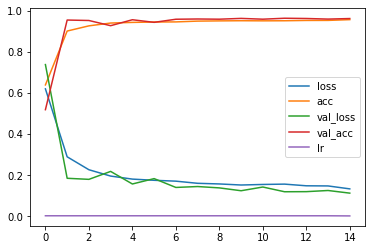

In [27]:
pd.DataFrame(cnn.history.history).plot()

In [28]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

428/428 [==============================] - 142s 332ms/step - loss: 0.1170 - acc: 0.9612
The testing accuracy is : 96.11565470695496 %


In [29]:
preds = cnn.predict(test,verbose=1)

428/428 [==============================] - 138s 322ms/step


In [30]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

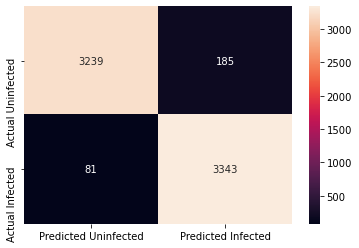

In [32]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Uninfected", "Actual Infected"],
columns=["Predicted Uninfected", "Predicted Infected"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [33]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['Uninfected','Infected']))

              precision    recall  f1-score   support

  Uninfected       0.98      0.95      0.96      3424
    Infected       0.95      0.98      0.96      3424

    accuracy                           0.96      6848
   macro avg       0.96      0.96      0.96      6848
weighted avg       0.96      0.96      0.96      6848



(6848, 500, 500, 1)
(6848,)


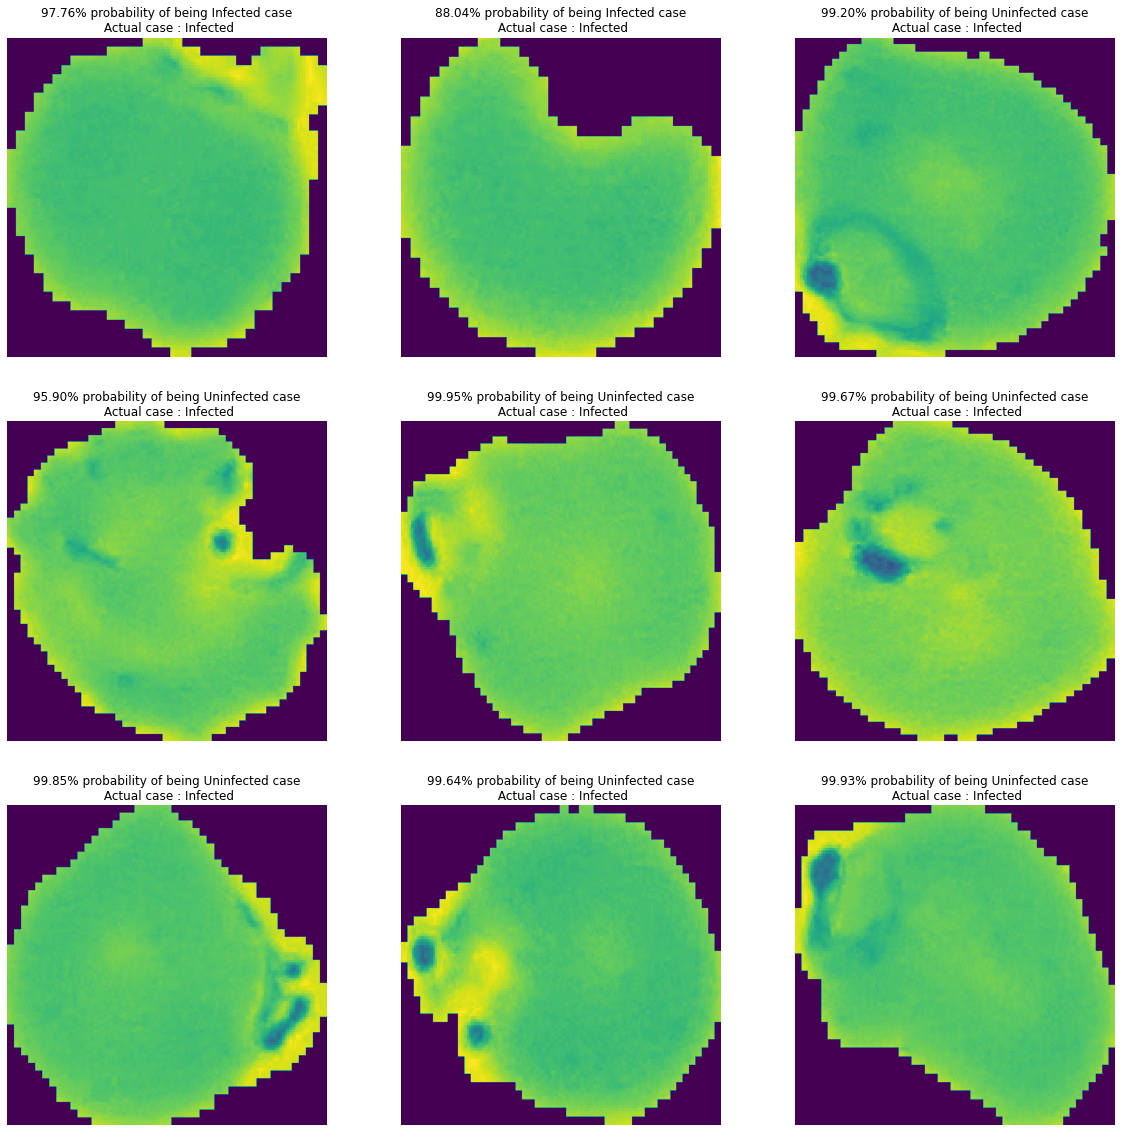

In [34]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 
dic = {0:'Infected', 1:'Uninfected'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Infected case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Uninfected case'.format(1-preds[i][0]))
  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()